In [1]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## Data Import

In [115]:
!wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv

--2021-01-03 10:41:06--  https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.128.133, 151.101.192.133, 151.101.0.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.128.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 417753 (408K) [text/plain]
Saving to: ‘time_series_covid19_confirmed_global.csv.1’

time_series_covid19 100%[===================>] 407.96K   758KB/s    in 0.5s    

2021-01-03 10:41:08 (758 KB/s) - ‘time_series_covid19_confirmed_global.csv.1’ saved [417753/417753]



In [13]:
df = pd.read_csv('./datasets/time_series_covid19_confirmed_global.csv')
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,12/23/20,12/24/20,12/25/20,12/26/20,12/27/20,12/28/20,12/29/20,12/30/20,12/31/20,1/1/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,50433,50655,50810,50886,51039,51280,51350,51405,51526,51526
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,54317,54827,55380,55755,56254,56572,57146,57727,58316,58316
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,96549,97007,97441,97857,98249,98631,98988,99311,99610,99897
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,7669,7699,7756,7806,7821,7875,7919,7983,8049,8117
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,16931,17029,17099,17149,17240,17296,17371,17433,17553,17568


## Exploratory Data Analysis

In [14]:
# Building a basic model for total cases does not rquire the location information
# Let’s start by getting rid of the first four columns:
df = df.iloc[:, 4:]

# Let’s check for missing values:
df.isnull().sum().sum()

0

Text(0.5, 1.0, 'Cumulative daily cases')

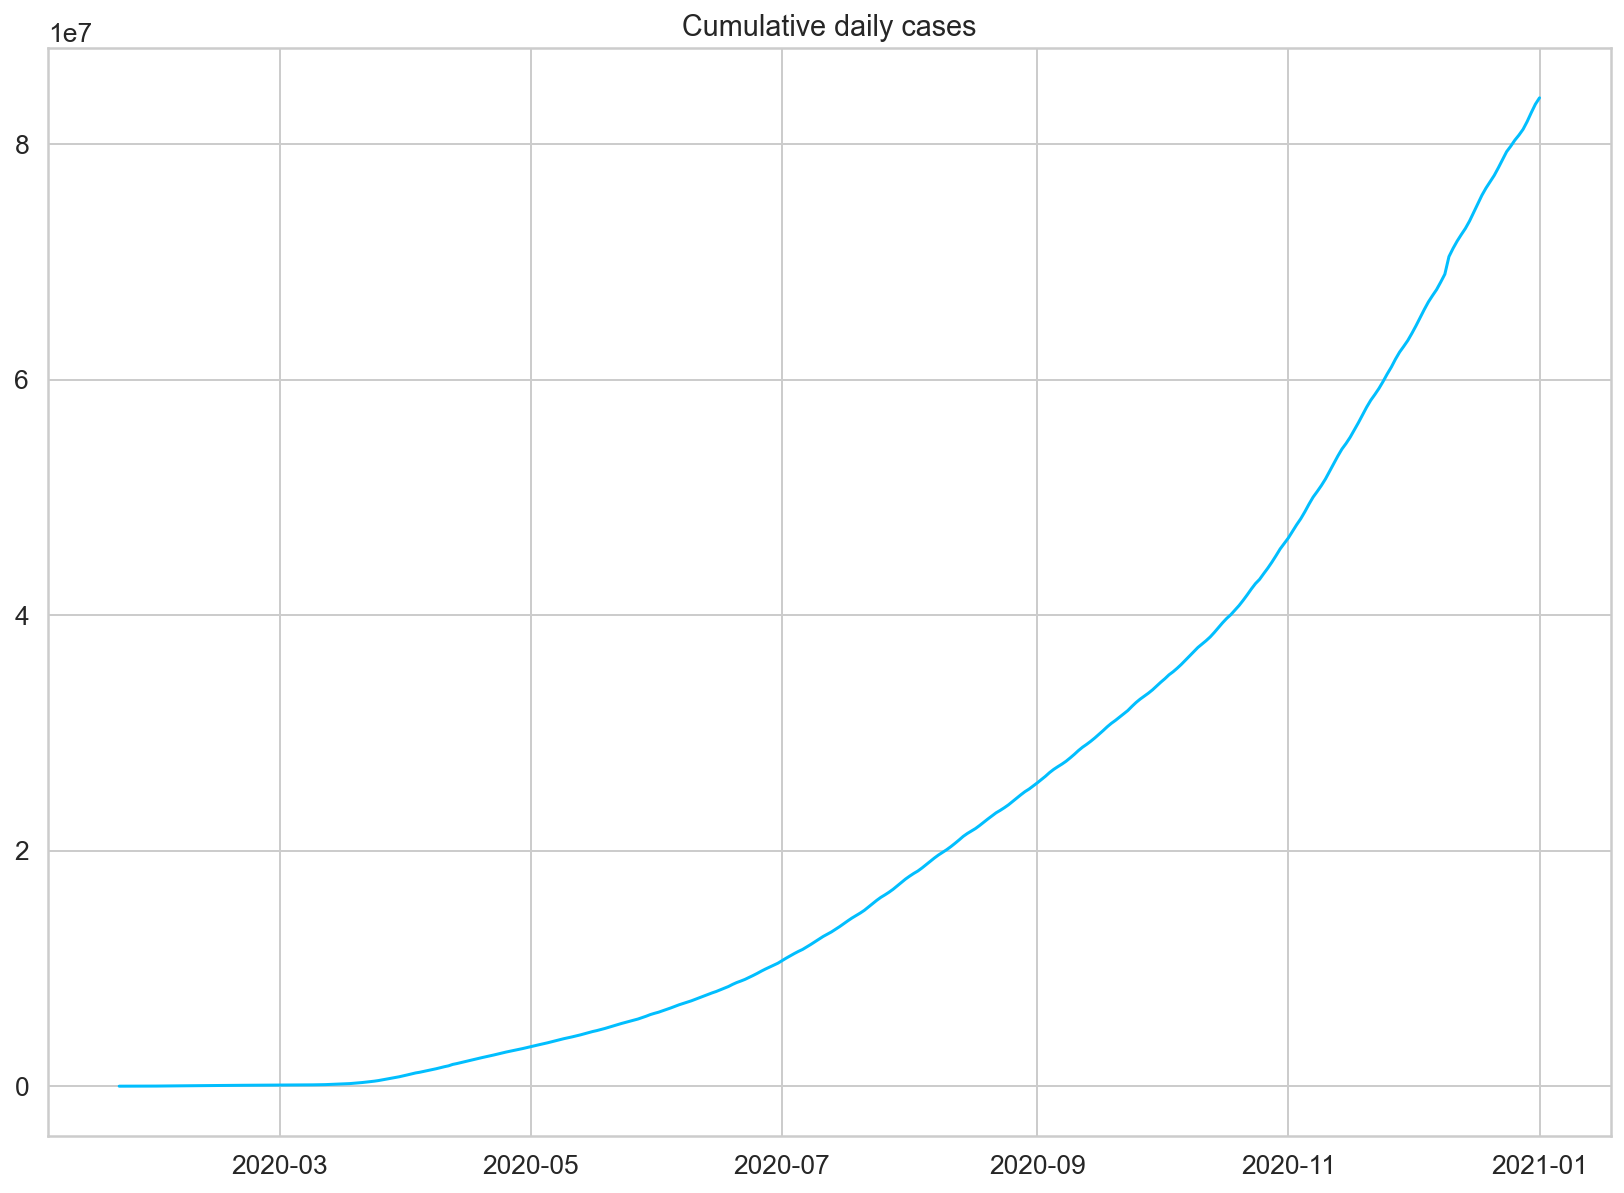

In [15]:
# Let’s sum all rows, so we get the cumulative daily cases:
daily_cases = df.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.head()

plt.plot(daily_cases)
plt.title("Cumulative daily cases")

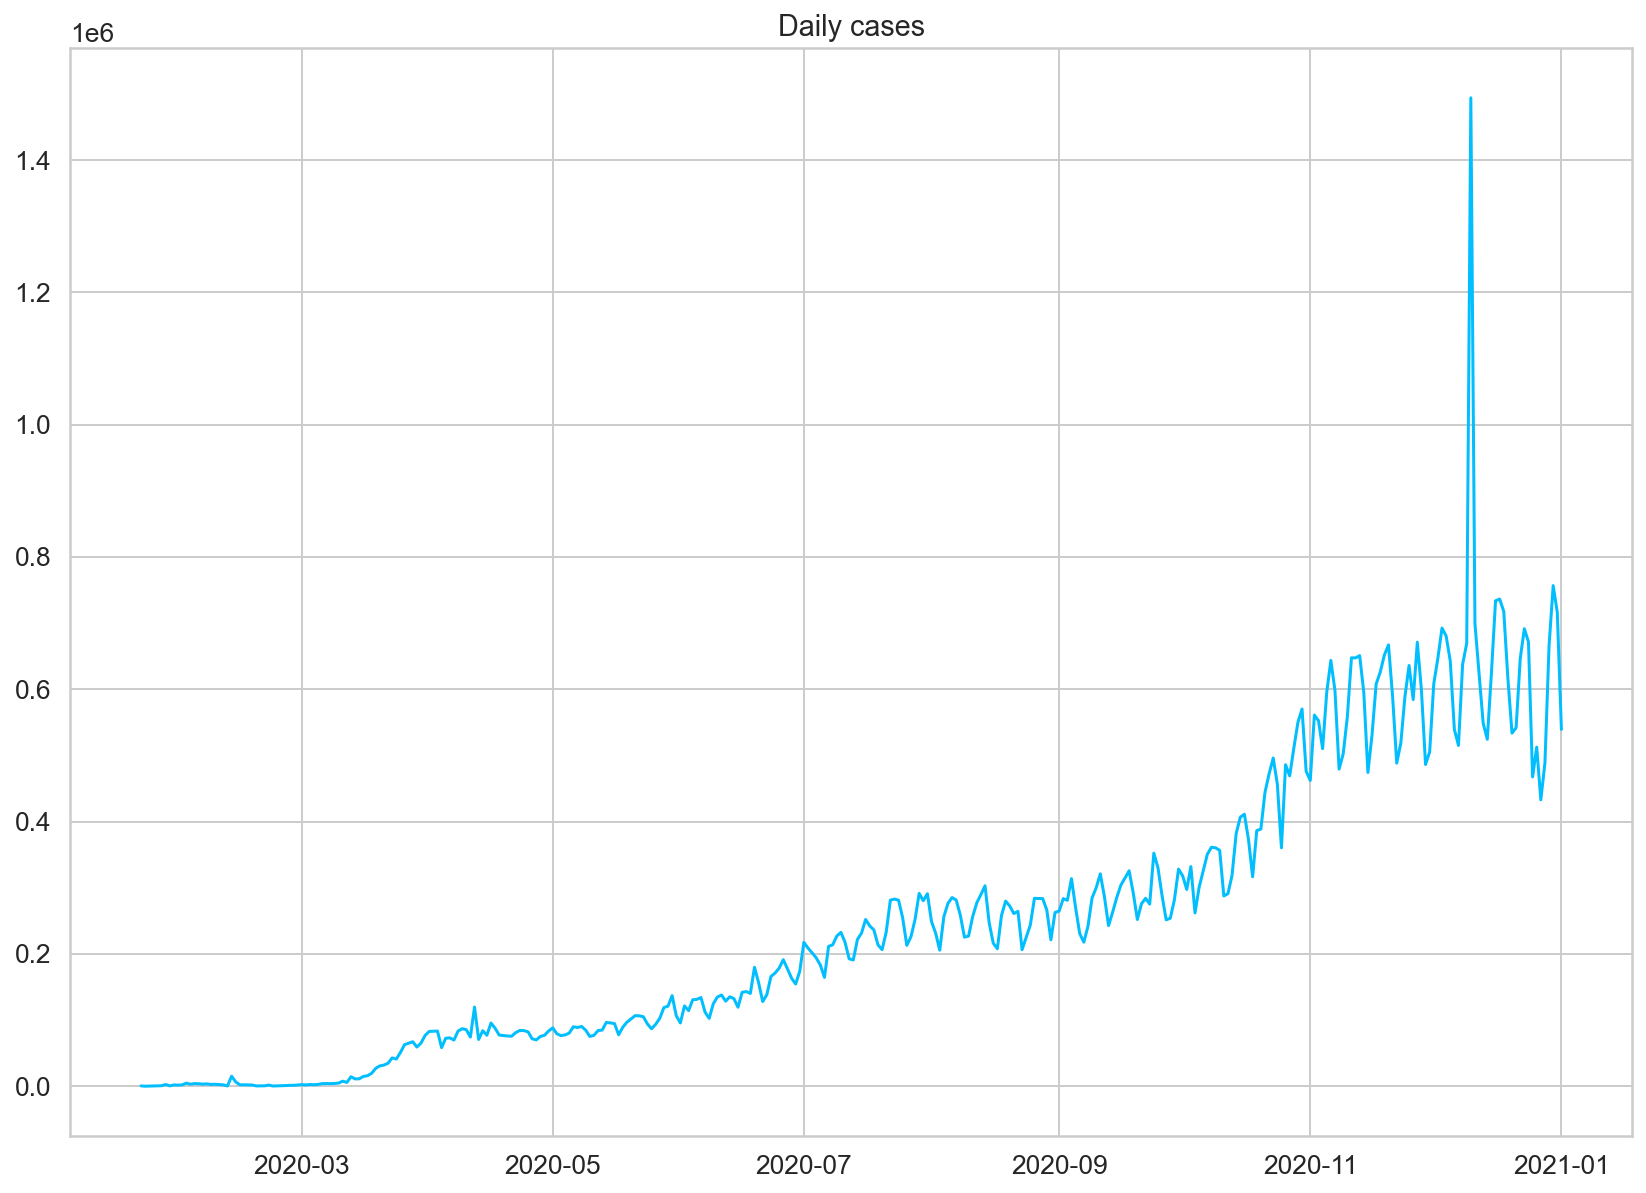

In [16]:
# We’ll undo the accumulation by subtracting the current value from the previous. We’ll preserve the first value of the sequence:
daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)
daily_cases.head()

plt.plot(daily_cases)
plt.title("Daily cases");

The huge spike (at the end) is mostly due to the december holiday period and the increased level of family gatherings - well, that's my assumption. This will certainly be a challenge for our model.

In [120]:
# Let's consider how many days of data we have to work with:
daily_cases.shape

(346,)

## Preprocessing

In [17]:
# We’ll reserve the first 300 days for training and use the rest for testing:

df.isnull().sum().sum()
train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]

In [18]:
# We have to scale the data (values will be between 0 and 1) if we want to increase the training speed and performance of the model.
scaler = MinMaxScaler()
scaler = scaler.fit(np.expand_dims(train_data, axis=1))
train_data = scaler.transform(np.expand_dims(train_data, axis=1))
test_data = scaler.transform(np.expand_dims(test_data, axis=1))

In [19]:
# Currently, we have a big sequence of daily cases. We’ll convert it into smaller ones:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [20]:
seq_length = 5

X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [21]:
# Each training example contains a sequence of 5 data points of history and a label for the real value that our model needs to predict. Let’s dive in:
X_train.shape

torch.Size([310, 5, 1])

In [22]:
X_train[:1]

tensor([[[0.0007],
         [0.0000],
         [0.0003],
         [0.0006],
         [0.0009]]])

In [23]:
y_train.shape

torch.Size([310, 1])

In [24]:
y_train[:2]

tensor([[0.0011],
        [0.0038]])

In [25]:
train_data[:10]

array([[0.00067959],
       [0.        ],
       [0.00028018],
       [0.00058719],
       [0.00087185],
       [0.00105814],
       [0.00380334],
       [0.00073026],
       [0.00293447],
       [0.0023741 ]])

## Build Model

In [26]:
# We’ll encapsulate the complexity of our model into a class that extends from torch.nn.Module:
class CoronaVirusPredictor(nn.Module):
  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()
    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers
    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )
    self.linear = nn.Linear(in_features=n_hidden, out_features=1)
  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )
  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

## Training

In [28]:
# Let’s build a helper function for the training of our model (we’ll reuse it later):
def train_model(
  model,
  train_data,
  train_labels,
  test_data=None,
  test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='sum')
  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = 60

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()
    y_pred = model(X_train)
    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)

      test_hist[t] = test_loss.item()
      print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')

    else:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

  return model.eval(), train_hist, test_hist

SyntaxError: invalid syntax (<ipython-input-28-ff7fe34046d2>, line 29)

In [153]:
model = CoronaVirusPredictor(
  n_features=1,
  n_hidden=512,
  seq_len=seq_length,
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model,
  X_train,
  y_train,
  X_test,
  y_test
)

Epoch 0 train loss: 2.928483486175537 test loss: 1669437.125
Epoch 10 train loss: 0.7875359654426575 test loss: 1610739.125
Epoch 20 train loss: 0.7452564835548401 test loss: 1588614.75
Epoch 30 train loss: 0.7021908164024353 test loss: 1559495.625
Epoch 40 train loss: 0.6871852874755859 test loss: 1527177.875
Epoch 50 train loss: 0.5718071460723877 test loss: 1514626.625


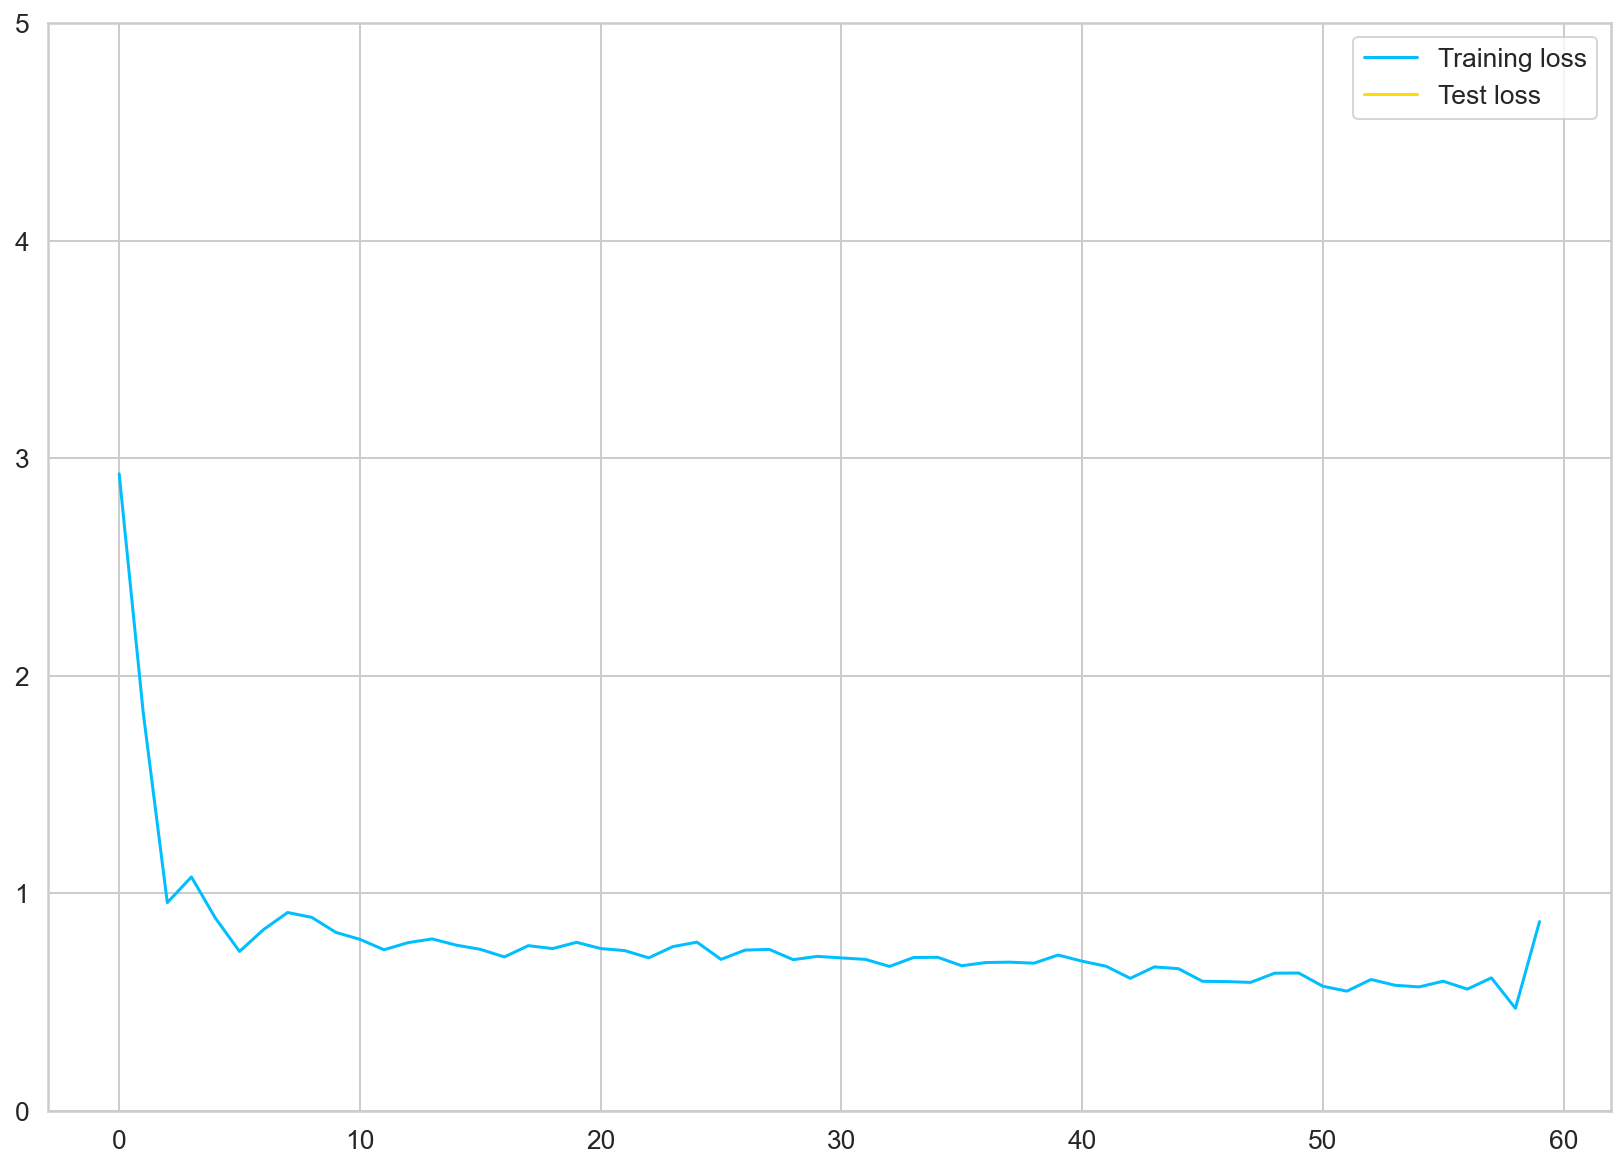

In [154]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 5))
plt.legend()

## Predicting Daily Cases

In [155]:
with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [156]:
true_cases = scaler.inverse_transform(np.expand_dims(y_test.flatten().numpy(),axis=0)).flatten()
predicted_cases = scaler.inverse_transform(np.expand_dims(preds, axis=0)).flatten()

In [158]:
len(train_data)

16

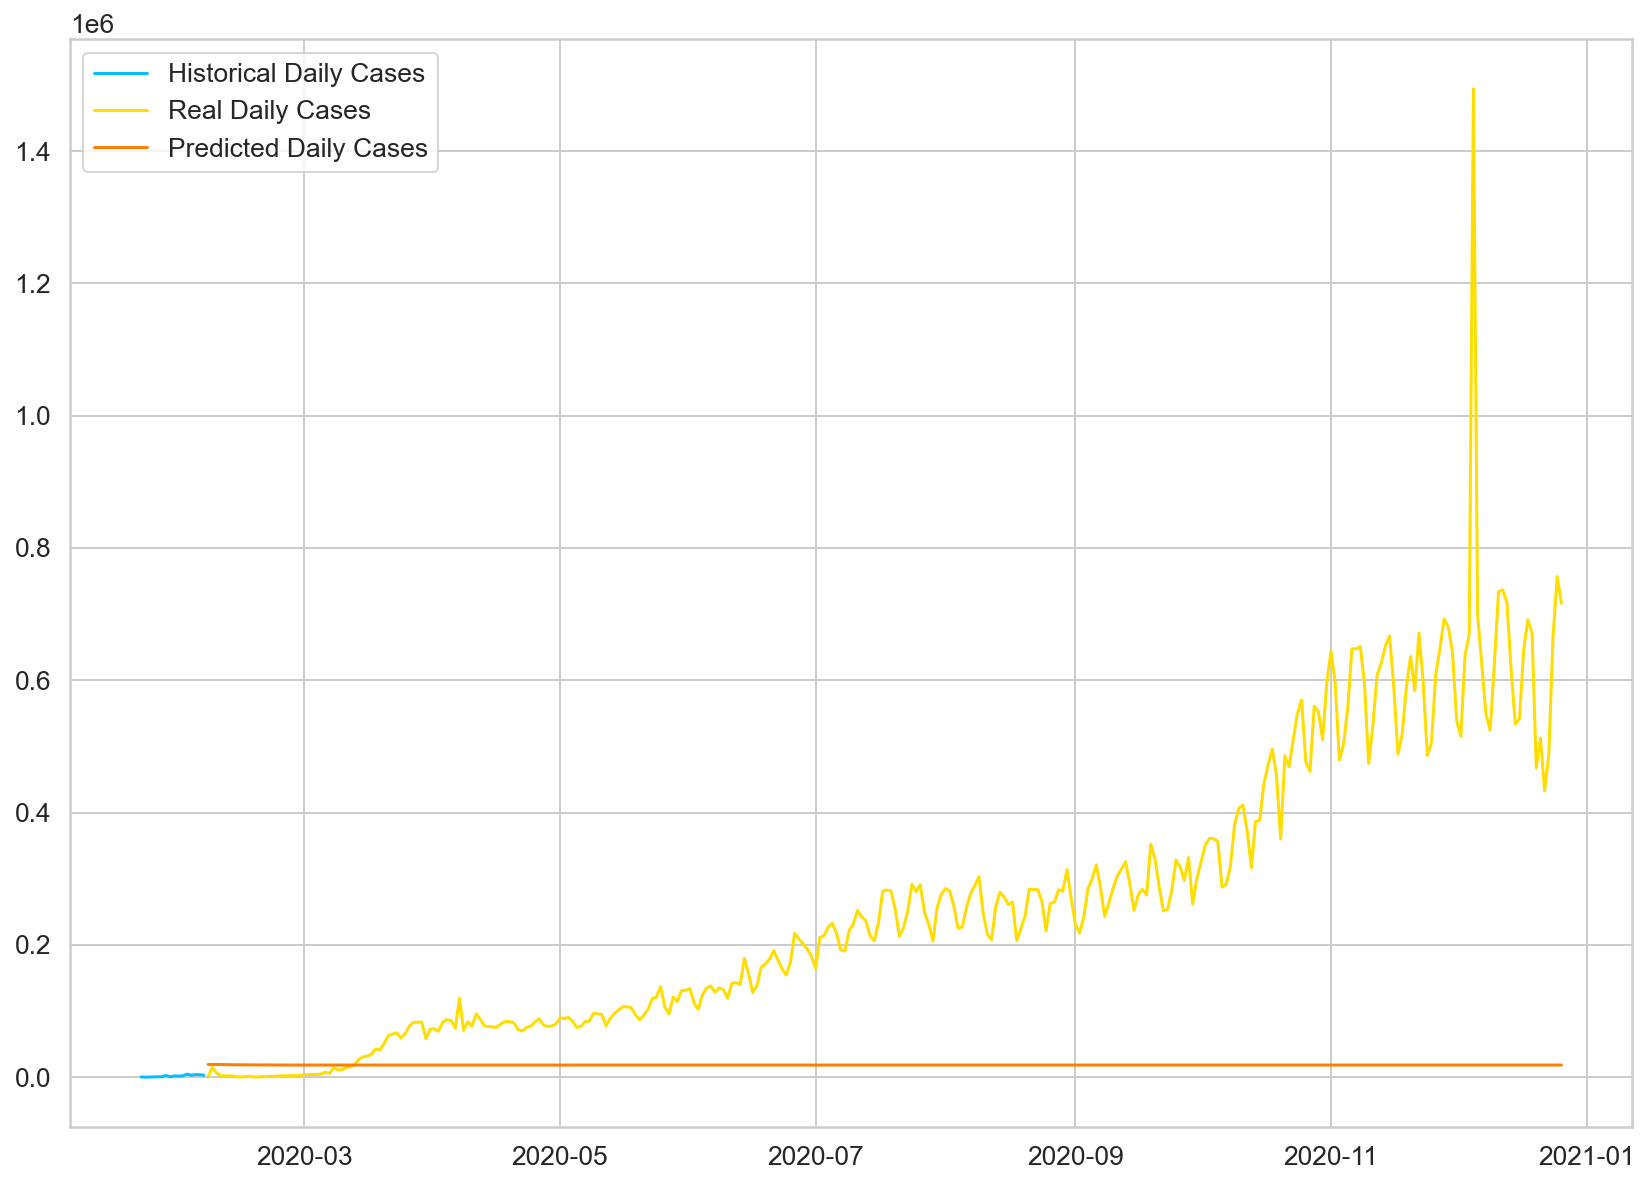

In [157]:
plt.plot(
  daily_cases.index[:len(train_data)],
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Cases'
)
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)],
  true_cases,
  label='Real Daily Cases'
)
plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)],
  predicted_cases,
  label='Predicted Daily Cases'
)
plt.legend()

In [97]:
scaler = MinMaxScaler()
scaler = scaler.fit(np.expand_dims(daily_cases, axis=1))
all_data = scaler.transform(np.expand_dims(daily_cases, axis=1))
all_data.shape

(346, 1)

In [98]:
X_all, y_all = create_sequences(all_data, seq_length)
X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()
model = CoronaVirusPredictor(
  n_features=1,
  n_hidden=512,
  seq_len=seq_length,
  n_layers=2
)
model, train_hist, _ = train_model(model, X_all, y_all)

Epoch 0 train loss: 3.7459487915039062
Epoch 10 train loss: 0.7397081851959229
Epoch 20 train loss: 0.7412723898887634
Epoch 30 train loss: 0.6937540769577026
Epoch 40 train loss: 0.6647000908851624
Epoch 50 train loss: 0.6034989953041077


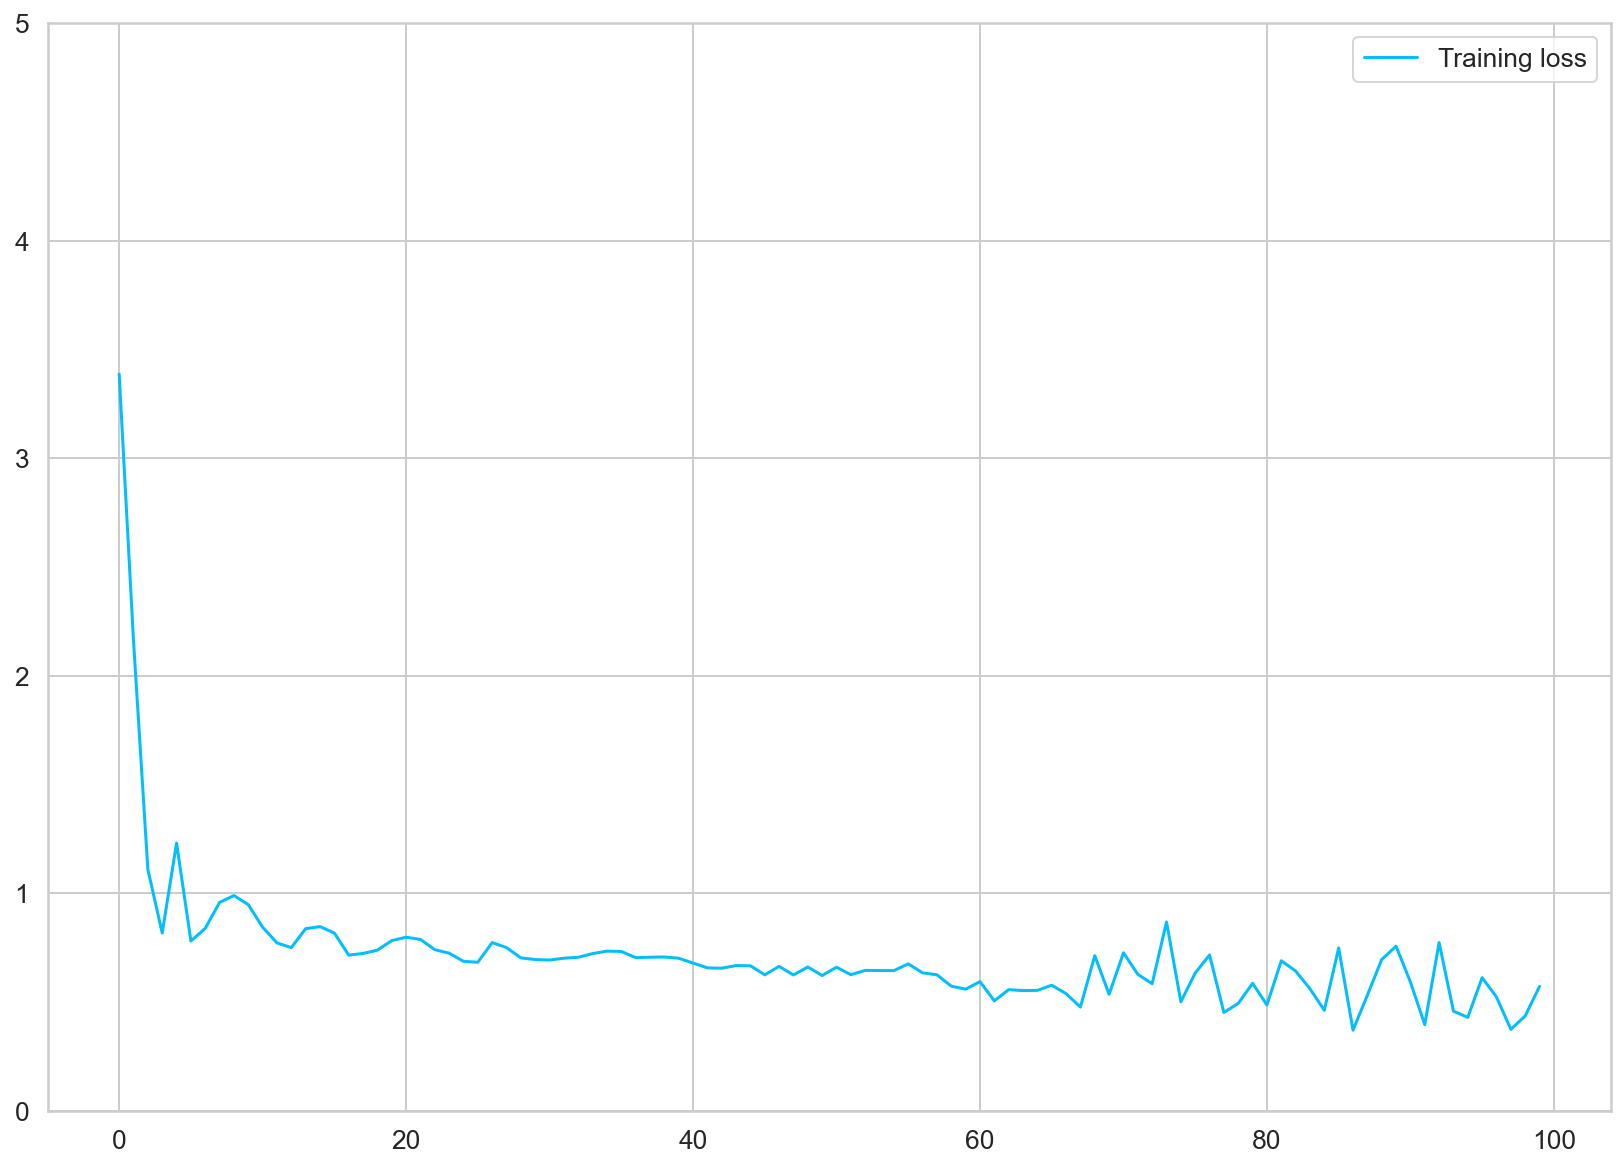

In [139]:
plt.plot(train_hist, label="Training loss")
plt.ylim((0, 5))
plt.legend()

In [109]:
DAYS_TO_PREDICT = 100

with torch.no_grad():
  test_seq = X_all[:1]
  preds = []
  for _ in range(DAYS_TO_PREDICT):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [110]:
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [111]:
daily_cases.index[-1]

Timestamp('2021-01-01 00:00:00')

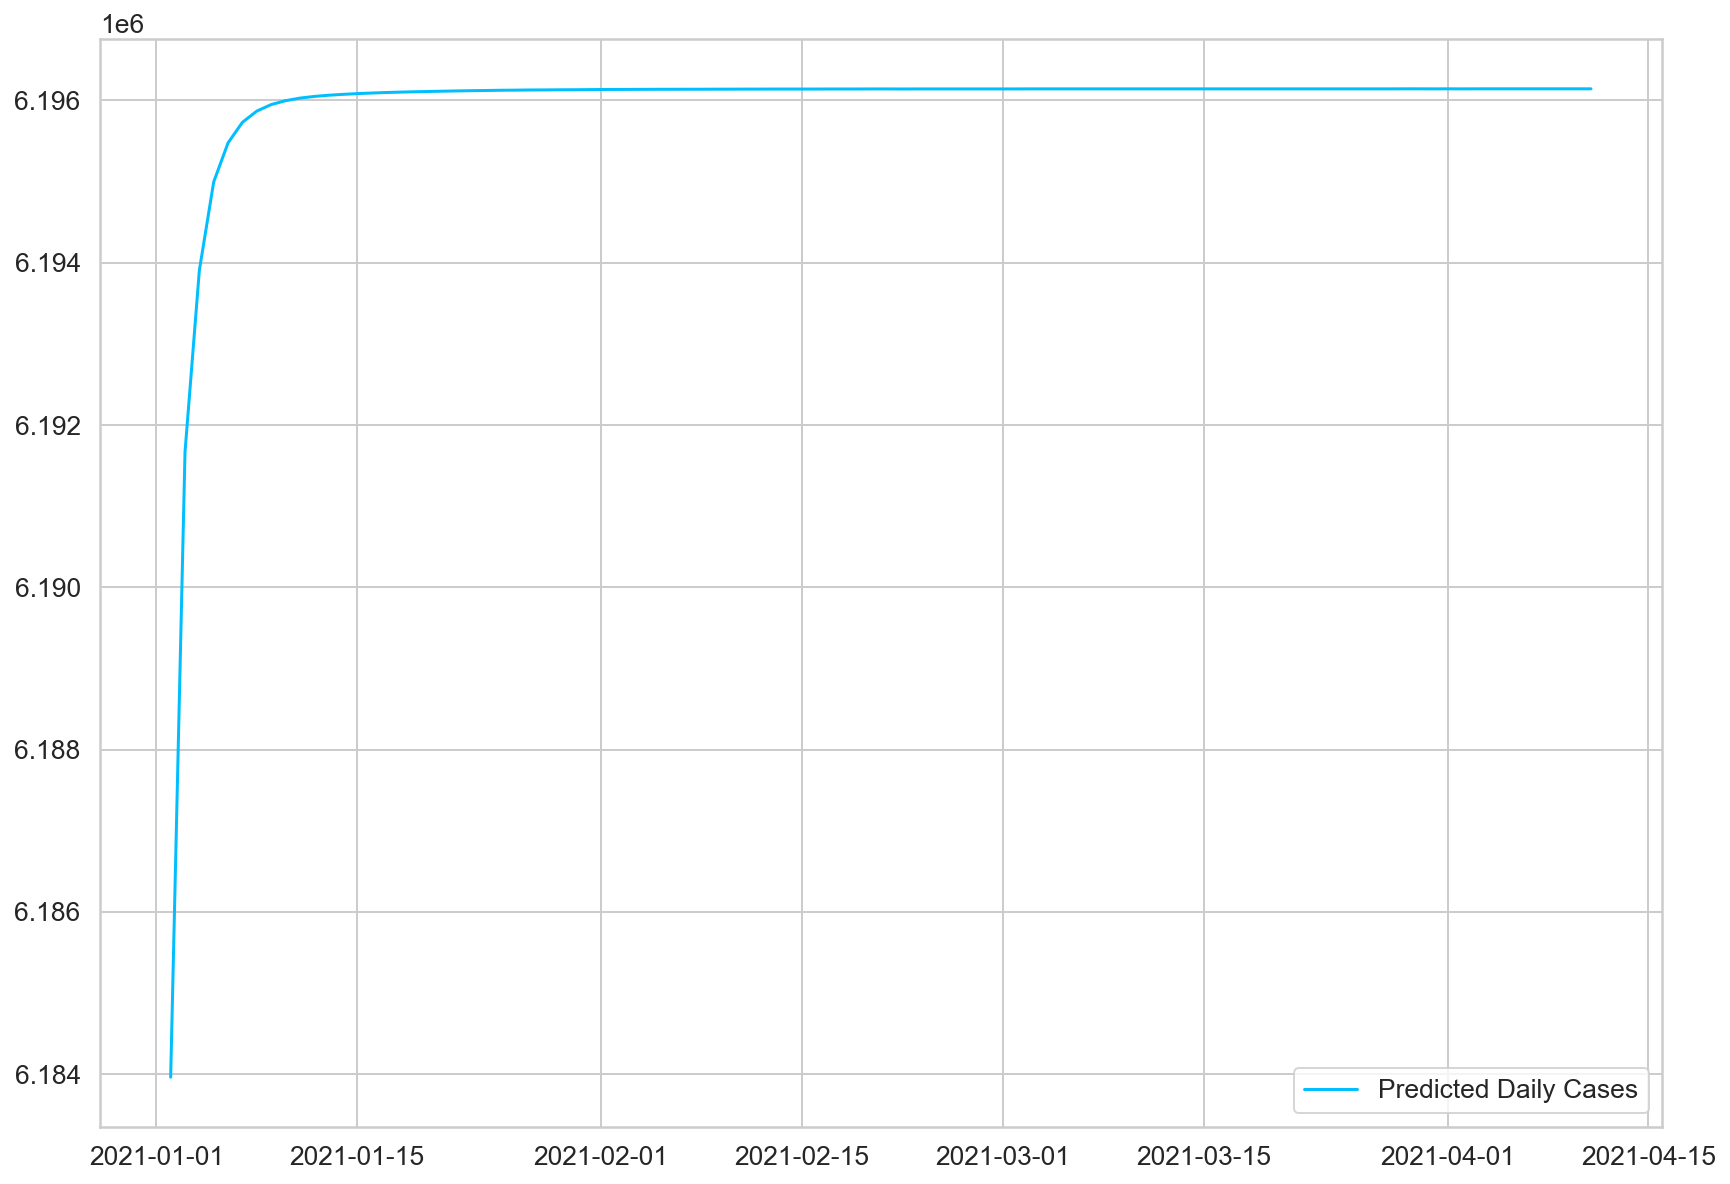

In [112]:
predicted_index = pd.date_range(
  start=daily_cases.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)
predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend()

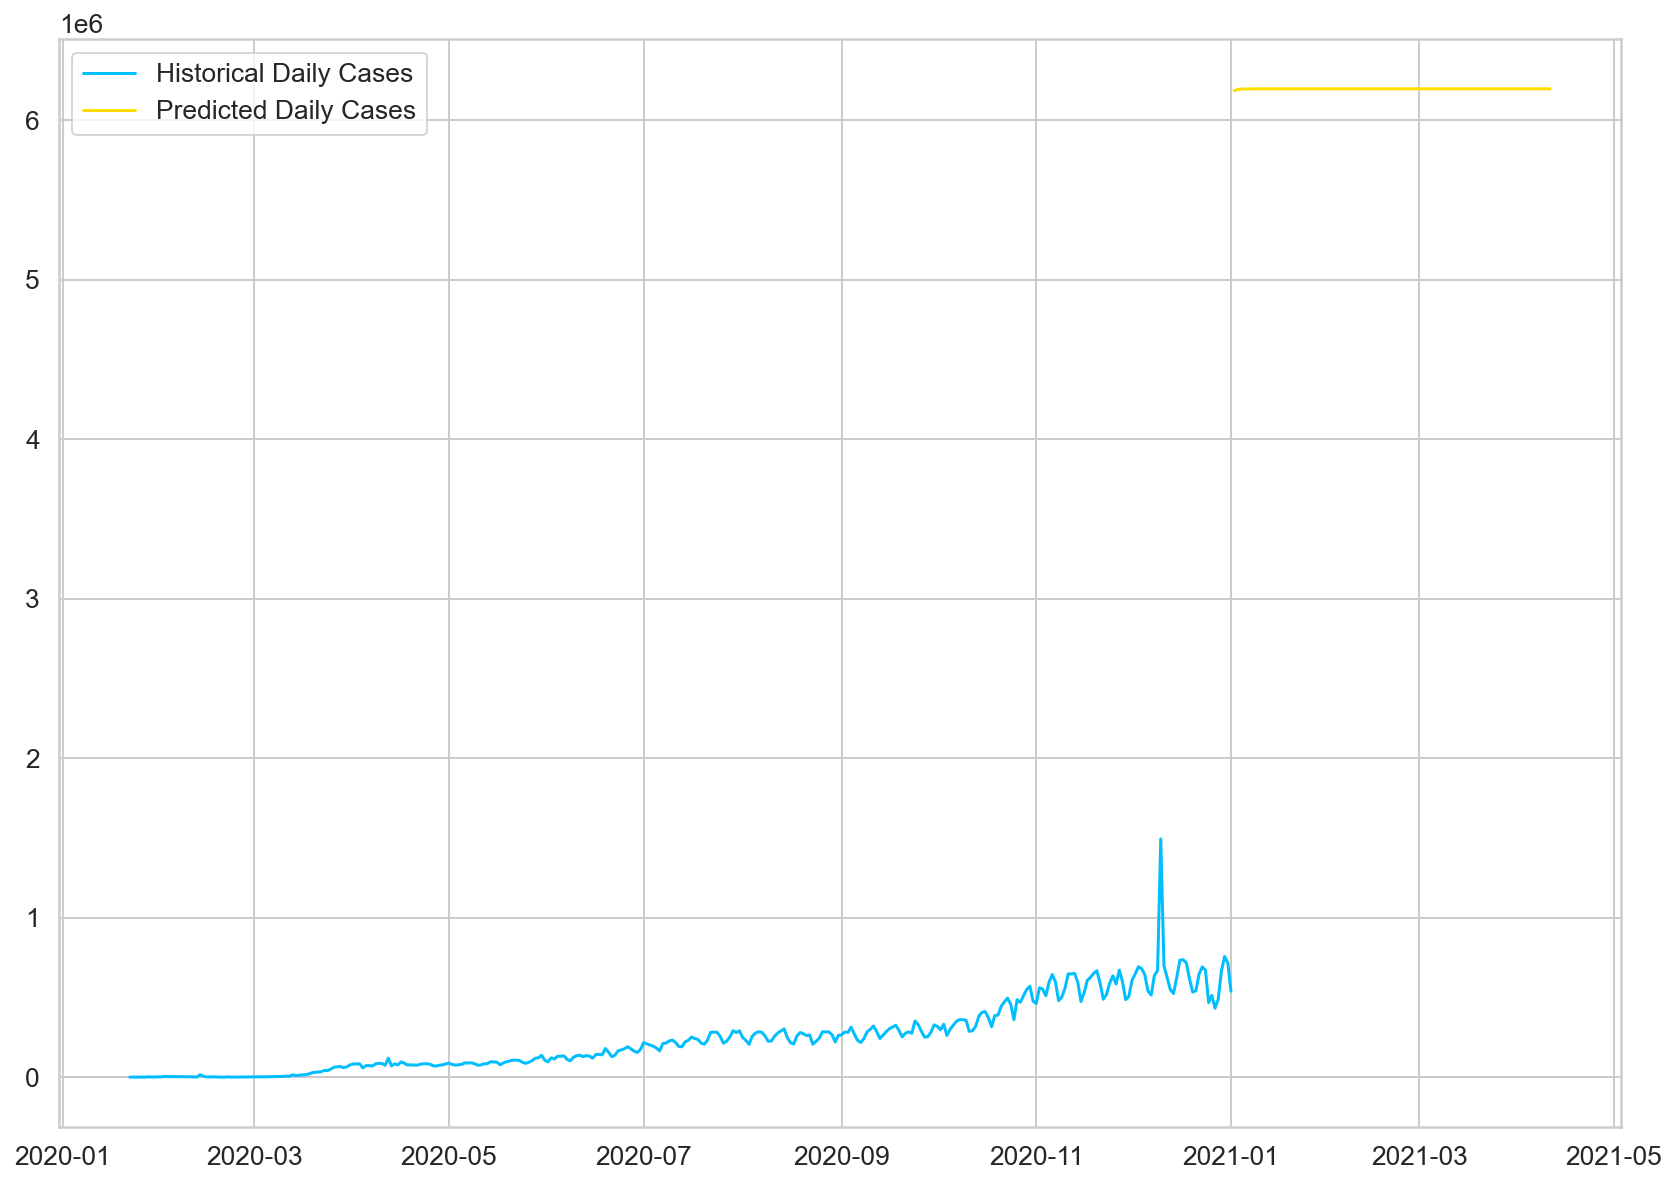

In [113]:
plt.plot(daily_cases, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend()